# Teste A/B

Em termos de Marketing Digital, Testes A/B são ferramentas importantes utilizadas para medir o feedback de um consumidor a uma alteração em um produto digital. Eles podem ser utilizados em uma grande variedade de canais e mídias e vão ajudar a compreender melhor como o seu consumidor reage a uma mudança no seu site ou aplicativo móvel.  

Parâmetros como a duração do teste e a extensão da mudança a ser testada devem ser definidos com base na sua taxa de acessos/downloads/instalações. Um teste A/B de uma simples mudança de cor de um botão, por exemplo, pode levar dias para capturar as informações necessárias para determinar se a mudança atingiu o objetivo ou não.
Você pode calcular aqui o tamanho necessário da amostra para um determinado teste: https://ferramentas.resultadosdigitais.com.br/calculadora-teste-ab/amostra  

Esse artigo destina-se a ser uma análise rápida dos dados resultantes de um teste A/B de um jogo para Android chamado Cookie Cats.
A ideia é analisar os efeitos na quantidade de níveis jogados com a adição de uma parada em dois momentos do jogo, após o nível 30 ou após o nível 40. Capturando dados de um número suficiente de jogadores, a equipe de desenvolvedores pode determinar qual o melhor curso de ação e ter uma melhor base para futuras mudanças.

Os dados foram obtidos no Kaggle, através do seguinte link: https://www.kaggle.com/yufengsui/mobile-games-ab-testing.
Serão utilizados packages básicos de Python:
- Pandas: para análise e manipulação dos dados
- Matplotlib: para apresentação de gráficos
- Scipy: para a realização de testes estatísticos


## Os dados

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew

%matplotlib inline
cookies = pd.read_csv('cookie_cats.csv')

In [49]:
cookies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
cookies.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Não há valores faltantes.
Temos **5** colunas com informações para **90189** usuários:
- userid - identificador único de usuário
- version - o grupo que o usuário foi colocado: controle (gate_30 - um portão no nível 30) ou teste (gate_40 - um portão no nível 40).
- sum_gamerounds - o número de fases jogadas nos primeiros 14 dias depois da instalação
- retention_1 - o jogador voltou a jogar 1 dia depois de instalar?
- retention_7 - o jogador voltou a jogar 7 dias depois de instalar?  


A coluna que nos interessa inicialmente é a coluna **sum_gamerounds**, pois queremos analisar se houve uma diferença no comportamento dos jogadores entre os que viram o portão no nível 30 e os que viram o portão no nível 40.

In [45]:
cookies.sum_gamerounds.nlargest(10)

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
46344     2251
87007     2156
36933     2124
88328     2063
6536      2015
Name: sum_gamerounds, dtype: int64

Há um claro **outlier**, um usuário que jogou 49854 níveis nos primeiros 14 dias depois de instalar o jogo. Dos 10 usuários que jogaram mais níveis, depois deste, ocorre uma queda mais natural. Vamos remover esse outlier para uma visão estatística mais simétrica.  
Obs: se outliers tão extremos fossem/forem mais comumente encontrados numa análise de dados a longo prazo, medidas diferentes poderiam ser tomadas.

In [64]:
cookies = cookies[cookies.sum_gamerounds < 10000]
cookies.sum_gamerounds.describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

Com o outlier removido, vemos que os usuários em média avançaram 51 níveis nos primeiros 14 dias, mas deve-se ter em mente que esse número está distorcido pela alta quantidade de níveis que poucos usuários avançaram.
Olhando os quartis, vemos que:
- 25% dos usuários avançaram de 0 a 5 níveis
- 50% dos usuários avançaram até 16 níveis
- 75% dos usuários avançaram até 51 níveis

In [60]:
df1 = cookies.groupby('sum_gamerounds').userid.agg(['count'])
df1['percent'] = 100*(df1['count']/90188)
df1['cumulative'] = 100*(df1['count'].cumsum() / df1['count'].sum())
df1.head(11)

,count,percent,cumulative
sum_gamerounds,,,
0,3994,4.428527,4.428527
1,5538,6.140506,10.569034
2,4606,5.107110,15.676143
3,3958,4.388610,20.064754
4,3629,4.023817,24.088571
5,2992,3.317515,27.406085
6,2861,3.172262,30.578347
7,2379,2.637823,33.216171
8,2267,2.513638,35.729809


Em mais detalhes, verificando os percentuais acumulados, vemos que:
- 3994 dos usuários, ou 4,43%, não avançaram nenhum nível
- 20% dos usuários avançaram 3 níveis ou menos
- 40% dos usuários chegaram até o 10º nível

Text(0.5, 0, 'Nº de rounds')

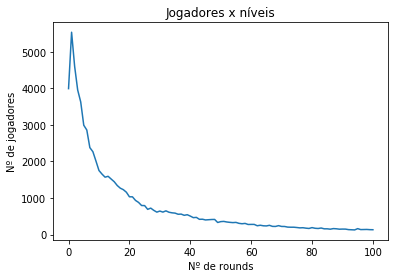

In [73]:
ax = cookies.groupby('sum_gamerounds').userid.count()[:101].plot()
ax.set_title("Jogadores x níveis")
ax.set_ylabel("Nº de jogadores")
ax.set_xlabel('Nº de níveis')

Representação gráfica do número de jogadores por número de níveis jogados. Nota-se uma queda bastante acentuada até 15 níveis, depois o número é razoavelmente nivelado.

## Grupos

In [31]:
cookies.groupby('version').sum_gamerounds.agg(['count','min','max','mean'])

,count,min,max,mean
version,,,,
gate_30,44699,0,2961,51.342111
gate_40,45489,0,2640,51.298776


Os usuários foram selecionados aleatoriamente e divididos em dois grupos, sendo:
- 44700 usuários no grupo controle
- 45489 usuários no grupo teste

A média de níveis jogados foi bem semelhante entre os dois grupos, 51,34 e 51,29 níveis, respectivamente

### Grupo de controle

Text(0.5, 1.0, 'Jogadores por Grupo (Controle)')

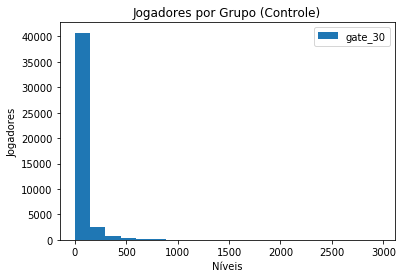

In [68]:
plt.hist(cookies[cookies.version == 'gate_30']['sum_gamerounds'],label='gate_30',bins=20)
plt.legend(loc='upper right')
plt.xlabel('Níveis')
plt.ylabel('Jogadores')
plt.title('Jogadores por Grupo (Controle)')

Como já verificado nos dados gerais, o mesmo ocorre no grupo de controle, uma distribuição extremamente assimétrica dos dados

In [65]:
skew(cookies[cookies.version == 'gate_30'].sum_gamerounds)

5.940197804240085

Isso também é evidenciado pelo alto índice de "Skewness" encontrado através do teste estatístico correspondente, **5,94** indica uma distribuição altamente assimétrica

### Grupo de teste

Text(0.5, 1.0, 'Jogadores por Grupo (Teste)')

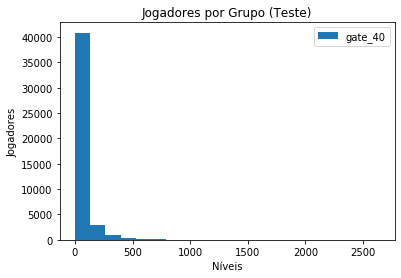

In [69]:
plt.hist(cookies[cookies.version == 'gate_40']['sum_gamerounds'],label='gate_40',bins=20)
plt.legend(loc='upper right')
plt.xlabel('Níveis')
plt.ylabel('Jogadores')
plt.title('Jogadores por Grupo (Teste)')

In [70]:
skew(cookies[cookies.version == 'gate_40'].sum_gamerounds)

5.967091125563528

Um número muito semelhante **5,96** também indica assimetria semelhante ao grupo de usuários de teste.
Porque dedicamos tempo à identificação da distribuição dos dados? Porque esse é um dos principais fatores utilizados na escolha do teste estatístico para determinar a significância dos dados encontrados.
Recapitulando, temos:
- Distribuição assimétrica (não-Normal)
- Amostras independentes (não se tratam dos mesmos jogadores, mas sim de um grupo totalmente diferente)
- Amostra de grande número

## Teste de significância
Aqui faremos um teste de hipótese para responder à pergunta: a mudança do portal do nível 30 para o 40 influencia o número de níveis jogados? Ou seja, fazer a mudança fez com que os usuários perdessem o interesse pelo jogo com tudo mais se mantendo da mesma forma?
- Hipótese nula (H0): não faz diferença
- Hipótese alternativa (H1): sim, influencia  

Com base nos parâmetros acima, foi utilizado o teste **Mann-Whitney U**, que é o teste não-paramétrico indicado para amostras independentes distribuídas de forma não-Normal.

In [8]:
scipy.stats.mannwhitneyu(*cookies.groupby('version')['sum_gamerounds'].apply(lambda x:list(x)), alternative='two-sided')

MannwhitneyuResult(statistic=1024331250.5, pvalue=0.050208807720442505)

Obs: O valor alto da estatística U se deve ao tamanho da amostra (mais de 40.000 usuários)

O p-value de **0.502** está ligeiramente acima do valor de corte estabelecido previamente de 0.05, mas atuando conservadoramente e com base no tamanho da amostra, podemos dizer que rejeita-se a hipótese de que as amostras são iguais, ou seja: com base nos dados coletados, houve diferença no número de níveis jogados entre os dois grupos.  
Ou ainda em termos mais naturais: **a melhor decisão é não mudar o portão para o nível 40.**

## Retenção de jogadores - 1 dia
Outra informação disponível nos dados é sobre a retenção, ou seja, um flag indicando se o jogador voltou a jogar um dia após instalar o jogo ou não

In [64]:
cookies.retention_1.mean()

0.4452095044850259

In [29]:
cookies.groupby('version').retention_1.mean()

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

Em média 44,52% dos jogadores voltaram no dia seguinte, com números bem semelhantes entre os dois grupos: 44,82% e 44,22%

## Retenção de jogadores - 7 dias
Da mesma forma, é possível analisar a retenção ao longo de 7 dias, um indicativo muito melhor de continuação de uso do app

In [65]:
cookies.retention_7.mean()

0.1860648194347426

In [72]:
cookies.groupby('version').retention_7.mean()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

Em média 18,6% dos jogadores voltaram em uma semana. Aqui os números não foram mais tão semelhantes, a diferença de 0,8% representa mais de 200 jogadores que não voltaram depois de 7 dias no grupo onde havia sido realizada a mudança.

## Conclusão  

Alguns insights que podem ser extraídos dos dados:
- Um jogador jogou 49500 níveis nos primeiros 14 dias, seria um erro na captura dos dados, um cheater?
- Muitos jogadores jogaram poucos níveis ou nenhum, mesmo os primeiros níveis do jogo sendo muito simples
- A média foi de 51 níveis por jogador, mas o número foi inflado devido ao número de jogadores que jogaram mais de 1000 níveis


Resultados do teste A/B:
- Apesar de não parecer de primeira vista, a mudança testada trouxe resultados positivos em termos de número de níveis jogados
